In [2]:
# unit test
import unittest

# model and transform
import torchvision
from torchvision import transforms
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
from torchvision.models.feature_extraction import get_graph_node_names

# "helper" needs to be part of sys path
import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

device="cpu"

%load_ext autoreload
%autoreload 2

# own module
from visualisation.deepdream import *

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


In [2]:
1.5**-7

0.05852766346593507

In [3]:
shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).stage3[0].branch1[0]

Conv2d(116, 116, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=116, bias=False)

In [3]:
class DeepDreamHighRes():
    # =============================================================================
    # https://github.com/juanigp/Pytorch-Deep-Dream/blob/master/Deep_Dream.ipynb
    # =============================================================================

    def __init__(self, model, layer, device="cpu", ckpt_net_path=None, out_channels=None, iterations=200, lr=1):
        # =============================================================================
        # Initialise iter, lr, model, layer
        # =============================================================================

        # settings for dreams
        self.iterations=iterations
        self.lr=lr
        self.device = device
        self.out_channels=out_channels

        # model
        if ckpt_net_path is not None:
            model.load_state_dict(torch.load(ckpt_net_path)["model"]) # 'dir/decentnet_epoch_19_0.3627.ckpt'
        self.model = model.eval()
        
        # the (conv) layer to be visualised
        self.layer = layer
        print("Layer:", self.layer)
    
    def _get_gradients(self, img):     
        # =============================================================================
        # Gradient calculations from output channels of the target layer  
        # =============================================================================
        img = img.unsqueeze(0).to(self.device)
        img.requires_grad = True
        self.model.zero_grad()
        hook = Hook(self.layer)
        _ = self.model(img)
        loss = hook.input[0].norm()
        if self.out_channels == None:
            loss = hook.output[0].norm()
        else:
            loss = hook.output[0][self.out_channels].norm()
        loss.backward()
        return img.grad.data.squeeze()

    def run(self, img_tensor):
        # =============================================================================
        # Torch dreams
        # =============================================================================
        self.img_tensor = img_tensor.to(self.device)
        
        img_numpy = img_tensor.detach().cpu().numpy()
        
        size = np.array([img_numpy.shape[1], img_numpy.shape[2]])
        
        
        print(size)

        OCTAVE_SCALE = 1.5
        for n in range(1): # -7,1
            for i in range(self.iterations):
                # gradients = self._get_gradients(self.img_tensor).datanew_size.astype
                # self.img_tensor.data = self.img_tensor.data + self.lr * gradients.data
                
                new_size = size * (OCTAVE_SCALE**n)
                
                # print(new_size)
                # img_tensor = img_tensor.resize(new_size.astype(int), Image.ANTIALIAS)
                torchvision.transforms.functional.resize(img_tensor, np.array(new_size).astype(int)) # .astype(int)
                # self.img_pil = dream(self.img_pil, self.model, self.layer, 50, 0.05, out_channels = None)

                roll_x = np.random.randint(img_numpy.shape[0])
                roll_y = np.random.randint(img_numpy.shape[1])
                img_roll = np.roll(np.roll(img_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
                img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float).to(self.device)
                gradients_np = self._get_gradients(img_roll_tensor).detach().cpu().numpy()
                gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
                gradients_tensor = torch.tensor(gradients_np).to(self.device)
                img_tensor.data = img_tensor.data + self.lr * gradients_tensor.data

            # make pillow image
            img_out = img_tensor.detach().cpu()
            img_out = img_out.numpy().transpose(1,2,0)
            img_out = np.clip(img_out, 0, 1)
            img_out = Image.fromarray(np.uint8(img_out * 255))
            self.img_pil = img_out

            
        
            

    def plot(self, size):
        # =============================================================================
        # Plot torch dream
        # =============================================================================
        # img = img.resize(orig_size)
        
        fig = plt.figure(figsize = (size , size))
        
        plt.imshow(self.img_pil)

**************************************************
example graph nodes: ['decent_block.decent_block_116.2.0.branch2.0', 'decent_block.decent_block_116.2.0.branch2.1', 'decent_block.decent_block_116.2.0.branch2.2', 'decent_block.decent_block_116.2.0.branch2.3', 'decent_block.decent_block_116.2.0.branch2.4', 'decent_block.decent_block_116.2.0.branch2.5', 'decent_block.decent_block_116.2.0.branch2.6', 'decent_block.decent_block_116.2.0.branch2.7', 'decent_block.decent_block_116.2.0.cat', 'decent_block.decent_block_116.2.0.size']
**************************************************
Layer: Conv2d(58, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
[128 132]


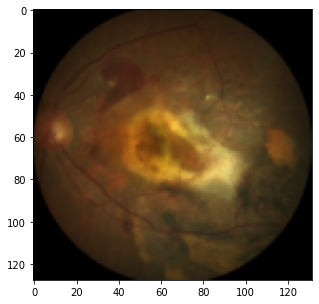

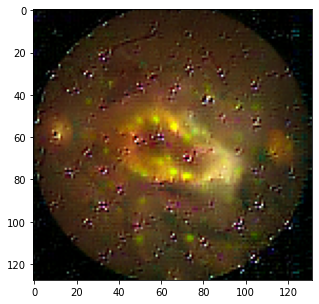

In [5]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

"""
img=Image.effect_noise((500, 500), 25).convert('RGB') 
"""
# tensor preparation
resize = transforms.Resize(128)
to_tensor = transforms.ToTensor()
img = resize(img)
fig = plt.figure(figsize = (5 , 5))
plt.imshow(img)
img = to_tensor(img).to(device)

# model preparation
#model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)

from model.decentblock import *
#model = DecentBlock(None, None, 2, device)
model = DecentBlock("example_ckpt", "exp_1_mlp_c0_ep46_1.5189.ckpt", 2, device)

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][10:20])
print("*"*50)
layer = model.decent_block.decent_block_116[2][3].branch2[0]
# model.decent_block.decent_block_reduction[0] # model.stage4[0].branch1[2] # model.fusion_layer # conv

# run deep dream
dd = DeepDreamHighRes(model=model, layer=layer, device=device, iterations=10, lr=0.1)
dd.run(img)
dd.plot(5)

**************************************************
example graph nodes: ['stage2.0.branch2.0', 'stage2.0.branch2.1', 'stage2.0.branch2.2', 'stage2.0.branch2.3', 'stage2.0.branch2.4', 'stage2.0.branch2.5', 'stage2.0.branch2.6', 'stage2.0.branch2.7', 'stage2.0.cat', 'stage2.0.size']
**************************************************
Layer: Conv2d(464, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
[224 231]


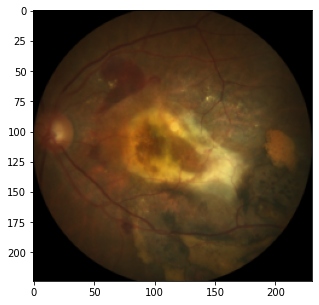

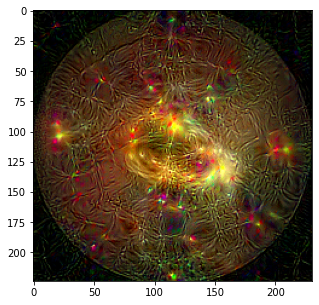

In [5]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

# img=Image.effect_noise((500, 500), 25).convert('RGB') 

# tensor preparation
resize = transforms.Resize(224)
to_tensor = transforms.ToTensor()
img = resize(img)
fig = plt.figure(figsize = (5 , 5))
plt.imshow(img)
img = to_tensor(img).to(device)

# model preparation
model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)

#from model.decentblock import *
#model = DecentBlock("example_ckpt", "exp_1_mlp_c3_ep43_1.2093.ckpt", 2, device)

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][10:20])
print("*"*50)
layer = model.conv5[0]# .stage3[0].branch1[0]
# layer = model.decent_block.decent_block_116[2][3].branch2[0]
# model.decent_block.decent_block_reduction[0] # model.stage4[0].branch1[2] # model.fusion_layer # conv

# run deep dream
dd = DeepDreamHighRes(model=model, layer=layer, device=device, iterations=100, lr=0.1)
dd.run(img)
dd.plot(5)

**************************************************
example graph nodes: ['decent_block.decent_block_116.2.0.branch2.0', 'decent_block.decent_block_116.2.0.branch2.1', 'decent_block.decent_block_116.2.0.branch2.2', 'decent_block.decent_block_116.2.0.branch2.3', 'decent_block.decent_block_116.2.0.branch2.4', 'decent_block.decent_block_116.2.0.branch2.5', 'decent_block.decent_block_116.2.0.branch2.6', 'decent_block.decent_block_116.2.0.branch2.7', 'decent_block.decent_block_116.2.0.cat', 'decent_block.decent_block_116.2.0.size']
**************************************************
Layer: Conv2d(58, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
[128 128]


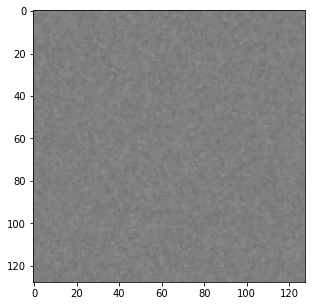

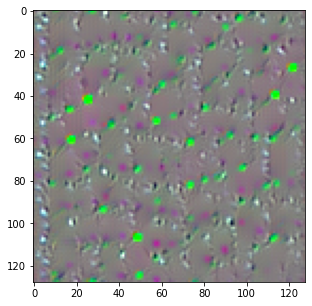

In [8]:
# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('example_data/eye')
img, label = ichallenge_data.__getitem__(1)

img=Image.effect_noise((500, 500), 25).convert('RGB') 

# tensor preparation
resize = transforms.Resize(128)
to_tensor = transforms.ToTensor()
img = resize(img)
fig = plt.figure(figsize = (5 , 5))
plt.imshow(img)
img = to_tensor(img).to(device)

# model preparation
#model = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1).to(device)

from model.decentblock import *
model = DecentBlock("example_ckpt", "exp_1_mlp_c5_ep36_1.1963.ckpt", 2, device)

# layer to focus on
print("*"*50)
print("example graph nodes:", get_graph_node_names(model)[0][10:20])
print("*"*50)
layer = model.decent_block.decent_block_116[2][3].branch2[0]
# model.decent_block.decent_block_reduction[0] # model.stage4[0].branch1[2] # model.fusion_layer # conv model.stage4[0].branch1[2] # 

# run deep dream
dd = DeepDreamHighRes(model=model, layer=layer, device=device, iterations=500, lr=0.01)
dd.run(img)
dd.plot(5)

In [4]:
one = 130/100

In [5]:
one

1.3

In [10]:
113/130*100

86.92307692307692

In [11]:
100-113/(130/100)

13.07692307692308